In [1]:
# Import the packages
import pandas as pd
# import bigquery
from google.cloud import bigquery
# from google.cloud import bigquery_storage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 100)

In [ ]:
from google.cloud import bigquery_storage

In [ ]:
#Instantiate the BQ client
client = bigquery.Client(project="dh-logistics-product-ops")
bqstorage_client = bigquery_storage.BigQueryReadClient()

In [2]:
# Declare some global inputs
test_names = ["'CL_20221201_R_B0_O_ElasticityCLRestaurants'"]
ld_lb_tg = "Low basket, low distance" # Low distance low basket clsuter
hd_lb_tg = "Low basket, high distance" # High Distance low basket cluster
central_tg = "Central cluster" # Central cluster
ld_hb_tg = "High basket, low distance" # Low distance high basket cluster
hd_hb_tg = "High basket, high distance" # High distance high basket cluster
test_start_date = "2022-12-01"
test_end_date = "2023-01-12"
num_bootstrap_samples = 1000 # Number of data points to have on the histogram
cl = 0.95
left_threshold = round((1 - cl) / 2, 4)
right_threshold = round((1 - (1 - cl) / 2), 4)

In [3]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

In [4]:
test_query_v2 = """ SELECT 
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,

        -- Location of order
        a.region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        -- Vendor data and information on the delivery
        a.vendor_id,
        e.cluster entity_cluster,
        v.cluster area_cluster,
        b.target_group AS target_group_bi,
        a.is_in_treatment,
        a.chain_id,
        a.chain_name,
        a.vertical_type,
        a.delivery_status,
        a.is_own_delivery,
        a.exchange_rate,

        -- Business KPIs (These are the components of profit)
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        a.gfv_local,
        a.gmv_local
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `logistics-data-storage-staging.long_term_pricing.vendors_clustered_entity` e on a.entity_id = e.entity_id and a.vendor_id = e.vendor_id 
    LEFT JOIN `logistics-data-storage-staging.long_term_pricing.vendors_clustered` v on v.entity_id = a.entity_id and a.vendor_id = v.vendor_id
    WHERE TRUE
        AND a.created_date between DATE("{test_start_date}") and DATE("{test_end_date}")
        AND b.test_name IN ({test_names})  -- Search for relevant tests
        AND a.is_sent -- Successful orders
        AND a.is_in_treatment = true 
        AND a.is_own_delivery -- OD orders only
        and e.cluster is not null
        and v.cluster is not null
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical""".format(test_names=', '.join(test_names), test_start_date=test_start_date, test_end_date=test_end_date)
# Execute the orders query
#df_test_data_2 = client.query(test_query_v2).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")
df_test_data_2 = pd.read_gbq(test_query_v2, project_id='logistics-customer-staging', dialect='standard')##, credentials=credentials)
df_test_data_2.head()


,created_date_utc,region,entity_id,country_code,city_name,city_id,zone_name,zone_id,variant,test_id,test_name,platform_order_code,scheme_id,vendor_price_scheme_type,vendor_id,entity_cluster,area_cluster,target_group_bi,is_in_treatment,chain_id,chain_name,vertical_type,delivery_status,is_own_delivery,exchange_rate,dps_delivery_fee_local,dps_travel_time_fee_local,dps_surge_fee_local,delivery_fee_local,gfv_local,gmv_local
0,2023-01-10,Americas,PY_CL,cl,Santiago,1,La montana,117,Variation1,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,710864244,634.000000000,Experiment,343250,"High basket, high distance","Low basket, high distance",Target Group 1,True,0011r00002VoHw4AAF,McDonald's,restaurants,completed,True,887.459090000,690.000000000,690.000000000,0E-9,690.000000000,2200.000000000,3240.000000000
1,2022-12-20,Americas,PY_CL,cl,Vina del mar,201,La calera,109,Control,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,698087840,635.000000000,Experiment,270253,Central cluster,"High basket, high distance",Target Group 1,True,0011r00002VoHw7AAF,Pizza Hut,restaurants,completed,True,940.309920000,1090.000000000,1090.000000000,0E-9,1090.000000000,9990.000000000,11480.000000000
2,2022-12-07,Americas,PY_CL,cl,Linares,228,Linares,108,Variation1,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,689339987,634.000000000,Experiment,5089,Central cluster,"High basket, low distance",Target Group 1,True,0011r00002VoHwZAAV,Telepizza,restaurants,completed,True,914.091530000,690.000000000,690.000000000,0E-9,690.000000000,5990.000000000,7030.000000000
3,2022-12-29,Americas,PY_CL,cl,Vina del mar,201,La calera,109,Control,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,703558507,635.000000000,Experiment,264655,Central cluster,"High basket, high distance",Target Group 1,True,0011r00002VoHw6AAF,Papa John's,restaurants,completed,True,912.145020000,1290.000000000,1290.000000000,0E-9,1640.000000000,8680.000000000,10320.000000000
4,2022-12-15,Americas,PY_CL,cl,Santiago,1,Cerrillos,122,Variation1,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,694476259,634.000000000,Experiment,66392,"Low basket, low distance","Low basket, low distance",Target Group 1,True,0011r00002VoHw4AAF,McDonald's,restaurants,completed,True,934.504870000,890.000000000,890.000000000,0E-9,890.000000000,3500.000000000,4740.000000000


In [5]:
df_control = df_test_data_2[df_test_data_2['variant']=="Control"]
df_variant_2 = df_test_data_2[df_test_data_2['variant']=='Variation1']
#df_variant_2 = df_test_data_2[df_test_data_2['variant']=='Variation2']
df_control
df_ctl = df_control[df_control["entity_cluster"] == ld_lb_tg]
df_ctl.head()

,created_date_utc,region,entity_id,country_code,city_name,city_id,zone_name,zone_id,variant,test_id,test_name,platform_order_code,scheme_id,vendor_price_scheme_type,vendor_id,entity_cluster,area_cluster,target_group_bi,is_in_treatment,chain_id,chain_name,vertical_type,delivery_status,is_own_delivery,exchange_rate,dps_delivery_fee_local,dps_travel_time_fee_local,dps_surge_fee_local,delivery_fee_local,gfv_local,gmv_local
6,2022-12-14,Americas,PY_CL,cl,Concepcion,200,San pedro,54,Control,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,693875013,635.000000000,Experiment,300979,"Low basket, low distance","Low basket, low distance",Target Group 1,True,0016900002f86bkAAA,Tokio Wok,restaurants,completed,True,928.356160000,690.000000000,690.000000000,0E-9,690.000000000,5600.000000000,0E-9
7,2022-12-23,Americas,PY_CL,cl,Linares,228,Linares,108,Control,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,700029044,635.000000000,Experiment,276070,"Low basket, low distance","Low basket, low distance",Target Group 1,True,0011r00002VoISxAAN,Tarragona,restaurants,completed,True,936.564300000,490.000000000,490.000000000,0E-9,490.000000000,4990.000000000,5830.000000000
35,2022-12-23,Americas,PY_CL,cl,Santiago,1,Estación central bicicleta,123,Control,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,699925323,635.000000000,Experiment,127557,"Low basket, low distance","Low basket, low distance",Target Group 1,True,0011r00002VoHw2AAF,KFC,restaurants,completed,True,936.564300000,490.000000000,490.000000000,0E-9,490.000000000,7280.000000000,8120.000000000
38,2022-12-08,Americas,PY_CL,cl,Linares,228,Linares,108,Control,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,689663718,635.000000000,Experiment,276070,"Low basket, low distance","Low basket, low distance",Target Group 1,True,0011r00002VoISxAAN,Tarragona,restaurants,completed,True,909.978420000,1290.000000000,1290.000000000,0E-9,1290.000000000,10470.000000000,12180.000000000
40,2022-12-11,Americas,PY_CL,cl,Linares,228,Linares,108,Control,63.000000000,CL_20221201_R_B0_O_ElasticityCLRestaurants,691922298,635.000000000,Experiment,276070,"Low basket, low distance","Low basket, low distance",Target Group 1,True,0011r00002VoISxAAN,Tarragona,restaurants,completed,True,904.933080000,690.000000000,690.000000000,0E-9,1040.000000000,7990.000000000,9030.000000000


In [6]:
# Run the bootstrapping function sequentially
vendor_labels = ["Low Basket, low Distance", "Low basket, high distance", "Central cluster", "High basket, low distance", "High basket, high distance"]
sim_results = []
sim_counter = 1
#for i in test_names:
for j in vendor_labels:
        # Filter the data based on the test
        #df_sub_test = df_test_data[df_test_data["target_group_bi"] == i]

        # Filter the simple LBs data frame to the right set of vendors based on the ASA ID that belong to the test
       # relevant_vendor_cluster = simple_lbs[simple_lbs["asa_id"] == int(df_sub_test["asa_id_of_test"].unique()[0])]
        
        # Further filter the data based on the vendor labels
    print(j)
    if j == "Low Basket, low Distance":
        df_var = df_variant_2[df_variant_2["entity_cluster"] == ld_lb_tg]
        df_ctl = df_control[df_control["entity_cluster"] == ld_lb_tg]
       # print(df_ctl)
    elif j == "Low Basket, high Distance":
        df_var = df_variant_2[df_variant_2["entity_cluster"] == hd_lb_tg]
        df_ctl = df_control[df_control["entity_cluster"] == hd_lb_tg]
    elif j == "Central cluster":
        df_var = df_variant_2[df_variant_2["entity_cluster"] == central_tg]
        df_ctl = df_control[df_control["entity_cluster"] == central_tg]
    elif j == "Low distance, high basket":
        df_var = df_variant_2[df_variant_2["entity_cluster"] == ld_hb_tg]
        df_ctl = df_control[df_control["entity_cluster"] == ld_hb_tg]
    elif j == "High Basket, high distance":
        df_var = df_variant_2[df_variant_2["entity_cluster"]== hd_hb_tg]
        df_ctl = df_control[df_control["entity_cluster"] == hd_hb_tg]
        
        # Elasticity calculated by pct difference in no. of transactions / pct difference in average DF
    for k in range(1, num_bootstrap_samples + 1):
        print(f"Iteration {sim_counter}. Sampling with the following parameters --> vendor_group_label: {j}, sample_num: {k}")
                    #df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
        df_ctl_sample = df_ctl.sample(frac = 1, replace = True)
            #df_var_sample = df_sub_test[df_sub_test["variant"] == "Variation2"].sample(frac=1, replace=True)
        df_var_sample = df_var.sample(frac=1, replace = True)
        num_orders_ctl = df_ctl_sample["platform_order_code"].nunique()
        num_orders_var = df_var_sample["platform_order_code"].nunique()

            # avg_df_ctl = df_ctl_sample["delivery_fee_local"].avg()
            # avg_df_var = df_var_sample["delivery_fee_local"].avg()
        avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
        avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var

        pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
        pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)

        elasticity = pct_diff_orders / pct_diff_avg_df

        output_dict = {
            "test_name": 'CL_20221201_R_B0_O_ElasticityCLRestaurants',
            "vendor_group_label": j,
            "sample_num": k,
            "elasticity": elasticity,
            "pct_diff_orders": pct_diff_orders,
            "pct_diff_avg_df": pct_diff_avg_df,
        }

        sim_results.append(output_dict)
            
            # Increment the sim counter
        sim_counter += 1

df_sim_results = pd.DataFrame(sim_results)

Low Basket, low Distance
Iteration 1. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 1
Iteration 2. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 2
Iteration 3. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 3
Iteration 4. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 4
Iteration 5. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 5
Iteration 6. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 6
Iteration 7. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 7
Iteration 8. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 8
Iteration 9. Sampling with the following parame

In [7]:
df_sim_results.head()

,test_name,vendor_group_label,sample_num,elasticity,pct_diff_orders,pct_diff_avg_df
0,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",1,-0.119613,-0.027780,0.232250
1,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",2,-0.092442,-0.020769,0.224666
2,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",3,-0.108034,-0.024840,0.229923
3,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",4,-0.123572,-0.029185,0.236174
4,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",5,-0.109294,-0.025030,0.229015


In [8]:
# Calculate the mean elasticity of LBs, non-LBs, and simple LBs per test
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"elasticity": list_of_agg_functions, "pct_diff_orders": list_of_agg_functions, "pct_diff_avg_df": list_of_agg_functions}
df_stats = df_sim_results.groupby(["test_name", "vendor_group_label"])[["elasticity", "pct_diff_orders", "pct_diff_avg_df"]].agg(agg_func_selection).reset_index()
df_stats

test_name          vendor_group_label  \
                                                                            
0  CL_20221201_R_B0_O_ElasticityCLRestaurants             Central cluster   
1  CL_20221201_R_B0_O_ElasticityCLRestaurants  High basket, high distance   
2  CL_20221201_R_B0_O_ElasticityCLRestaurants   High basket, low distance   
3  CL_20221201_R_B0_O_ElasticityCLRestaurants    Low Basket, low Distance   
4  CL_20221201_R_B0_O_ElasticityCLRestaurants   Low basket, high distance   

  elasticity                                  pct_diff_orders                  \
        mean percentile_left percentile_right            mean percentile_left   
0  -0.119190       -0.134426        -0.102627       -0.025062       -0.028854   
1  -0.118421       -0.134354        -0.101222       -0.024855       -0.028749   
2  -0.119561       -0.136571        -0.103146       -0.025137       -0.029276   
3  -0.114704       -0.129810        -0.098439       -0.026660       -0.030862   
4  -0.115187       -0.130696        -0.098882       -0.026790       -0.030924   

                   pct_diff_avg_df                                   
  percentile_right            mean percentile_left percentile_right  
0        -0.021055        0.210111        0.204382         0.215965  
1        -0.020804        0.209715        0.203665         0.215149  
2        -0.021074        0.210069        0.204210         0.216293  
3        -0.022451        0.232245        0.225611         0.238415  
4        -0.022475        0.232407        0.225838         0.238722

In [9]:
min_elas = -4.0
max_elas = 4.0
df_sim_filtered = df_sim_results[(df_sim_results['elasticity'] >= min_elas) & (df_sim_results['elasticity'] <= max_elas)]
df_sim_filtered

,test_name,vendor_group_label,sample_num,elasticity,pct_diff_orders,pct_diff_avg_df
0,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",1,-0.119613,-0.027780,0.232250
1,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",2,-0.092442,-0.020769,0.224666
2,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",3,-0.108034,-0.024840,0.229923
3,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",4,-0.123572,-0.029185,0.236174
4,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",5,-0.109294,-0.025030,0.229015
...,...,...,...,...,...,...
4995,CL_20221201_R_B0_O_ElasticityCLRestaurants,"High basket, high distance",996,-0.133482,-0.028456,0.213182
4996,CL_20221201_R_B0_O_ElasticityCLRestaurants,"High basket, high distance",997,-0.108052,-0.022447,0.207746
4997,CL_20221201_R_B0_O_ElasticityCLRestaurants,"High basket, high distance",998,-0.105067,-0.021605,0.205625
4998,CL_20221201_R_B0_O_ElasticityCLRestaurants,"High basket, high distance",999,-0.109617,-0.022847,0.208423


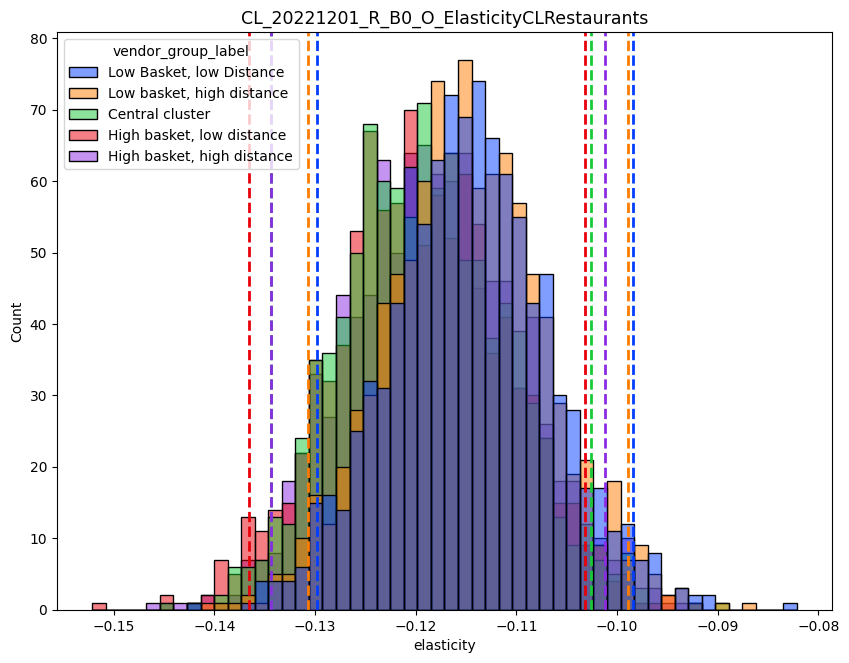

In [10]:
fig, axes = plt.subplots(figsize = (10,7.5))
def plot_func_single(test_name, kpi):
    pal = sns.color_palette("bright", len(df_sim_filtered['vendor_group_label'].unique()))
    sns.histplot(data=df_sim_filtered[df_sim_filtered["test_name"] == test_name], x=kpi, hue="vendor_group_label", palette=pal)

    for idx, var in enumerate(df_sim_filtered['vendor_group_label'].unique()):
        # Retrieve the percentile_left and percentile_right of the variant
        percentile_left = df_stats[(df_stats["test_name"] == test_name) & (df_stats['vendor_group_label'] == var)][kpi]\
        .reset_index(drop=True)["percentile_left"][0]
        percentile_right = df_stats[(df_stats["test_name"] == test_name) & (df_stats['vendor_group_label'] == var)][kpi]\
        .reset_index(drop=True)["percentile_right"][0]

        # Plot the 
        axes.axvline(x = percentile_left, ymin=0, ymax=1, color=pal[idx], linestyle="--", linewidth=2)
        axes.axvline(x = percentile_right, ymin=0, ymax=1, color=pal[idx], linestyle="--", linewidth=2)

    axes.set_title(test_name, size = 12.5)

# Plot the graph
plot_func_single(test_name=test_names[0].replace("'", ""), kpi="elasticity")

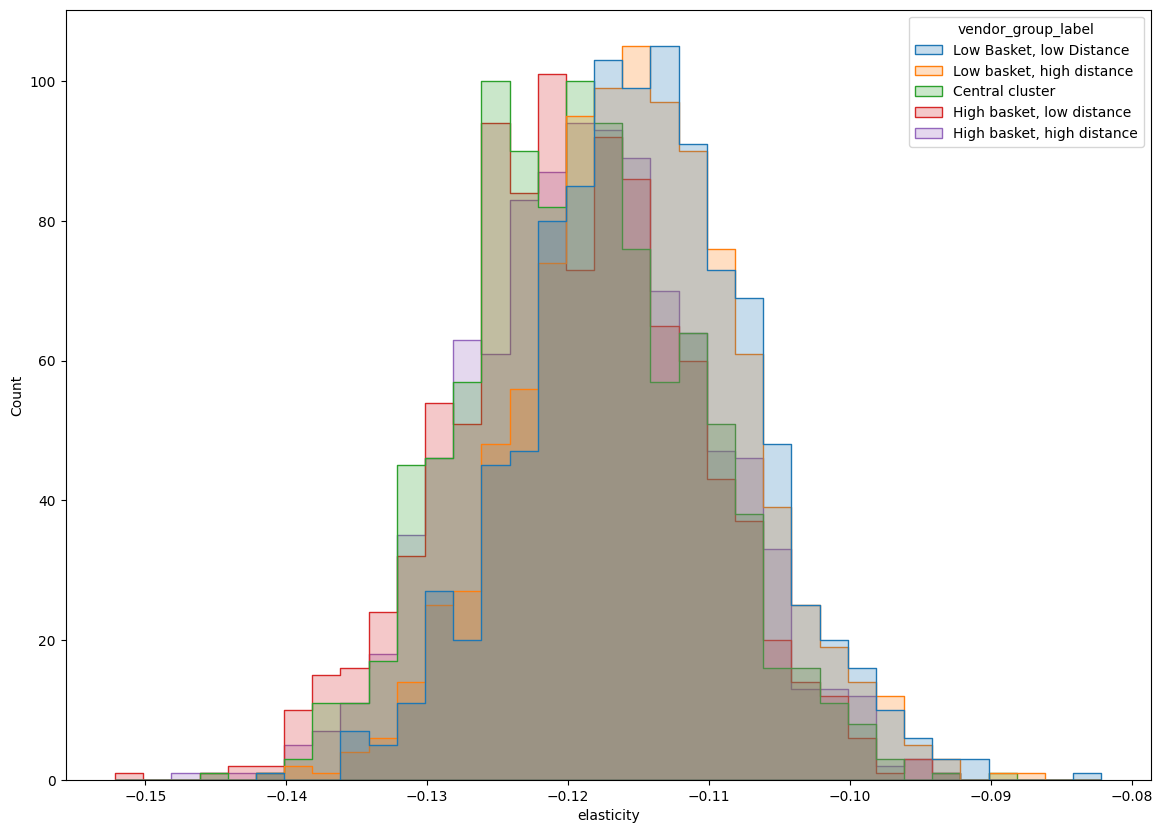

In [11]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.histplot(df_sim_filtered,x='elasticity',hue='vendor_group_label',element = 'step', binwidth = 0.002, ax = ax)
plt.show()

In [12]:
max_elas = df_sim_results['elasticity'].max()
min_elas = df_sim_results['elasticity'].min()
max_elas, min_elas 

(-0.0821628844885012, -0.15215532668892384)

In [13]:
## Clustering at entity area

In [14]:
# Run the bootstrapping function sequentially
vendor_labels = ["Low Basket, low Distance", "Low basket, high distance", "Central cluster", "High basket, low distance", "High basket, high distance"]
sim_results = []
sim_counter = 1
#for i in test_names:
for j in vendor_labels:
        # Filter the data based on the test
        #df_sub_test = df_test_data[df_test_data["target_group_bi"] == i]

        # Filter the simple LBs data frame to the right set of vendors based on the ASA ID that belong to the test
       # relevant_vendor_cluster = simple_lbs[simple_lbs["asa_id"] == int(df_sub_test["asa_id_of_test"].unique()[0])]
        
        # Further filter the data based on the vendor labels
    print(j)
    if j == "Low Basket, low Distance":
        df_var = df_variant_2[df_variant_2["area_cluster"] == ld_lb_tg]
        df_ctl = df_control[df_control["area_cluster"] == ld_lb_tg]
       # print(df_ctl)
    elif j == "Low Basket, high Distance":
        df_var = df_variant_2[df_variant_2["area_cluster"] == hd_lb_tg]
        df_ctl = df_control[df_control["area_cluster"] == hd_lb_tg]
    elif j == "Central cluster":
        df_var = df_variant_2[df_variant_2["area_cluster"] == central_tg]
        df_ctl = df_control[df_control["area_cluster"] == central_tg]
    elif j == "Low distance, high basket":
        df_var = df_variant_2[df_variant_2["area_cluster"] == ld_hb_tg]
        df_ctl = df_control[df_control["area_cluster"] == ld_hb_tg]
    elif j == "High Basket, high distance":
        df_var = df_variant_2[df_variant_2["area_cluster"]== hd_hb_tg]
        df_ctl = df_control[df_control["area_cluster"] == hd_hb_tg]
        
        # Elasticity calculated by pct difference in no. of transactions / pct difference in average DF
    for k in range(1, num_bootstrap_samples + 1):
        print(f"Iteration {sim_counter}. Sampling with the following parameters --> vendor_group_label: {j}, sample_num: {k}")
                    #df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
        df_ctl_sample = df_ctl.sample(frac = 1, replace = True)
            #df_var_sample = df_sub_test[df_sub_test["variant"] == "Variation2"].sample(frac=1, replace=True)
        df_var_sample = df_var.sample(frac=1, replace = True)
        num_orders_ctl = df_ctl_sample["platform_order_code"].nunique()
        num_orders_var = df_var_sample["platform_order_code"].nunique()

            # avg_df_ctl = df_ctl_sample["delivery_fee_local"].avg()
            # avg_df_var = df_var_sample["delivery_fee_local"].avg()
        avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
        avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var

        pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
        pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)

        elasticity = pct_diff_orders / pct_diff_avg_df

        output_dict = {
            "test_name": 'CL_20221201_R_B0_O_ElasticityCLRestaurants',
            "vendor_group_label": j,
            "sample_num": k,
            "elasticity": elasticity,
            "pct_diff_orders": pct_diff_orders,
            "pct_diff_avg_df": pct_diff_avg_df,
        }

        sim_results.append(output_dict)
            
            # Increment the sim counter
        sim_counter += 1

df_sim_results_2 = pd.DataFrame(sim_results)

Low Basket, low Distance
Iteration 1. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 1
Iteration 2. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 2
Iteration 3. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 3
Iteration 4. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 4
Iteration 5. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 5
Iteration 6. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 6
Iteration 7. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 7
Iteration 8. Sampling with the following parameters --> vendor_group_label: Low Basket, low Distance, sample_num: 8
Iteration 9. Sampling with the following parame

In [15]:
# Calculate the mean elasticity of LBs, non-LBs, and simple LBs per test
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"elasticity": list_of_agg_functions, "pct_diff_orders": list_of_agg_functions, "pct_diff_avg_df": list_of_agg_functions}
df_stats_2 = df_sim_results_2.groupby(["test_name", "vendor_group_label"])[["elasticity", "pct_diff_orders", "pct_diff_avg_df"]].agg(agg_func_selection).reset_index()
df_stats_2

test_name          vendor_group_label  \
                                                                            
0  CL_20221201_R_B0_O_ElasticityCLRestaurants             Central cluster   
1  CL_20221201_R_B0_O_ElasticityCLRestaurants  High basket, high distance   
2  CL_20221201_R_B0_O_ElasticityCLRestaurants   High basket, low distance   
3  CL_20221201_R_B0_O_ElasticityCLRestaurants    Low Basket, low Distance   
4  CL_20221201_R_B0_O_ElasticityCLRestaurants   Low basket, high distance   

  elasticity                                  pct_diff_orders                  \
        mean percentile_left percentile_right            mean percentile_left   
0  -0.140795       -0.156346        -0.124239       -0.029458       -0.033410   
1  -0.140842       -0.155321        -0.124629       -0.029457       -0.033190   
2  -0.140753       -0.156211        -0.124118       -0.029431       -0.033347   
3  -0.096279       -0.111747        -0.079711       -0.022436       -0.026621   
4  -0.096358       -0.113082        -0.079687       -0.022459       -0.026994   

                   pct_diff_avg_df                                   
  percentile_right            mean percentile_left percentile_right  
0        -0.025308        0.209078        0.202827         0.215369  
1        -0.025480        0.209020        0.203470         0.214783  
2        -0.025253        0.208962        0.202966         0.214826  
3        -0.018217        0.232817        0.226641         0.239516  
4        -0.018209        0.232842        0.226123         0.239387

In [16]:
min_elas = -4.0
max_elas = 4.0
df_sim_filtered_2 = df_sim_results_2[(df_sim_results_2['elasticity'] >= min_elas) & (df_sim_results_2['elasticity'] <= max_elas)]
df_sim_filtered_2

,test_name,vendor_group_label,sample_num,elasticity,pct_diff_orders,pct_diff_avg_df
0,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",1,-0.087179,-0.020056,0.230059
1,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",2,-0.100310,-0.023091,0.230199
2,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",3,-0.100594,-0.023375,0.232367
3,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",4,-0.096016,-0.022262,0.231856
4,CL_20221201_R_B0_O_ElasticityCLRestaurants,"Low Basket, low Distance",5,-0.100568,-0.023550,0.234165
...,...,...,...,...,...,...
4995,CL_20221201_R_B0_O_ElasticityCLRestaurants,"High basket, high distance",996,-0.141287,-0.029487,0.208702
4996,CL_20221201_R_B0_O_ElasticityCLRestaurants,"High basket, high distance",997,-0.135999,-0.028458,0.209248
4997,CL_20221201_R_B0_O_ElasticityCLRestaurants,"High basket, high distance",998,-0.132133,-0.027022,0.204508
4998,CL_20221201_R_B0_O_ElasticityCLRestaurants,"High basket, high distance",999,-0.160734,-0.034971,0.217573


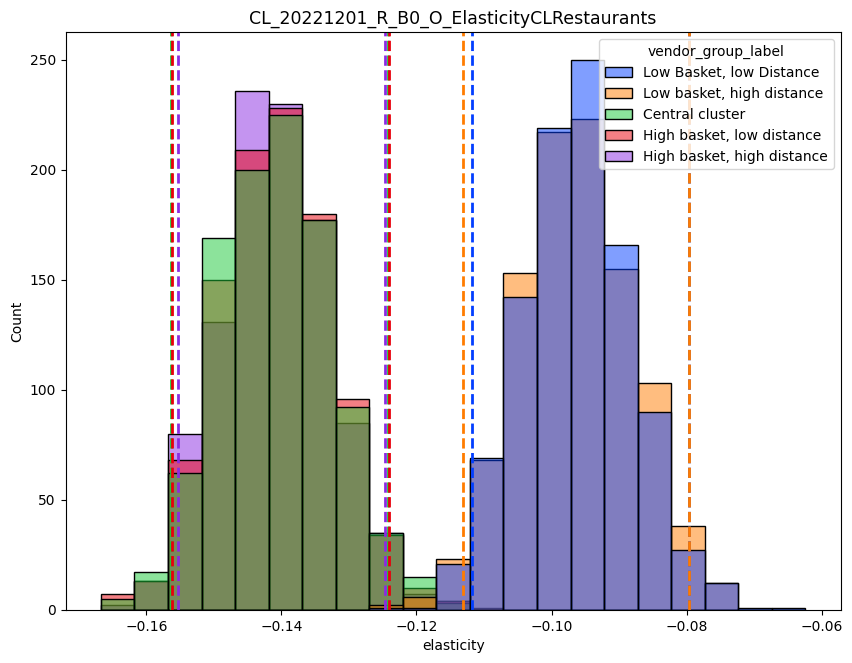

In [17]:
fig, axes = plt.subplots(figsize = (10,7.5))
def plot_func_single(test_name, kpi):
    pal = sns.color_palette("bright", len(df_sim_filtered_2['vendor_group_label'].unique()))
    sns.histplot(data=df_sim_filtered_2[df_sim_filtered_2["test_name"] == test_name], x=kpi, hue="vendor_group_label", palette=pal)

    for idx, var in enumerate(df_sim_filtered_2['vendor_group_label'].unique()):
        # Retrieve the percentile_left and percentile_right of the variant
        percentile_left = df_stats_2[(df_stats_2["test_name"] == test_name) & (df_stats_2['vendor_group_label'] == var)][kpi]\
        .reset_index(drop=True)["percentile_left"][0]
        percentile_right = df_stats_2[(df_stats_2["test_name"] == test_name) & (df_stats_2['vendor_group_label'] == var)][kpi]\
        .reset_index(drop=True)["percentile_right"][0]

        # Plot the 
        axes.axvline(x = percentile_left, ymin=0, ymax=1, color=pal[idx], linestyle="--", linewidth=2)
        axes.axvline(x = percentile_right, ymin=0, ymax=1, color=pal[idx], linestyle="--", linewidth=2)

    axes.set_title(test_name, size = 12.5)

# Plot the graph
plot_func_single(test_name=test_names[0].replace("'", ""), kpi="elasticity")

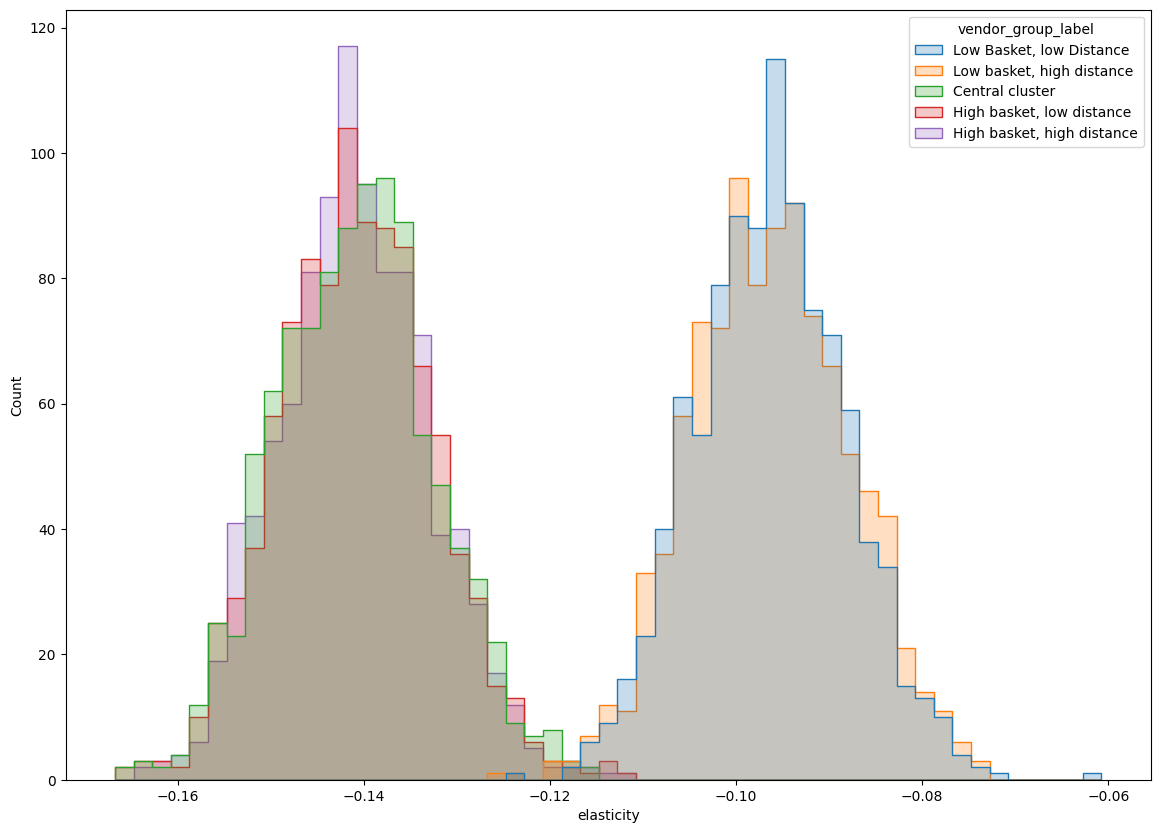

In [18]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.histplot(df_sim_filtered_2,x='elasticity',hue='vendor_group_label',element = 'step', binwidth = 0.002, ax = ax)
plt.show()